In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from pathlib import Path
import seaborn as sns 

In [4]:
DATA_DIR = Path("../data").absolute()
sunspots_df = pd.read_csv(DATA_DIR / "sunspots.csv", index_col=0)
sunspots_df.Date = sunspots_df.Date.astype("datetime64[m]")
sunspots_df.head()


,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [27]:
sunspots_df = sunspots_df.rename(columns={"Monthly Mean Total Sunspot Number": "sunspots"})
sunspots_test_df = sunspots_df[sunspots_df.Date >= "2015-01-01"]
sunspots_train_df = sunspots_df[sunspots_df.Date < "2015-01-01"]

In [28]:
print(f"Number of samples: {len(sunspots_df)}")
print(f"Number of missing values: {sunspots_df.isna().sum().sum()}")
print(f"Number of duplicated values: {sunspots_df.duplicated().sum()}")
print(f"date range: {sunspots_df.Date.min()} - {sunspots_df.Date.max()}")

Number of samples: 3265
Number of missing values: 0
Number of duplicated values: 0
date range: 1749-01-31 00:00:00 - 2021-01-31 00:00:00


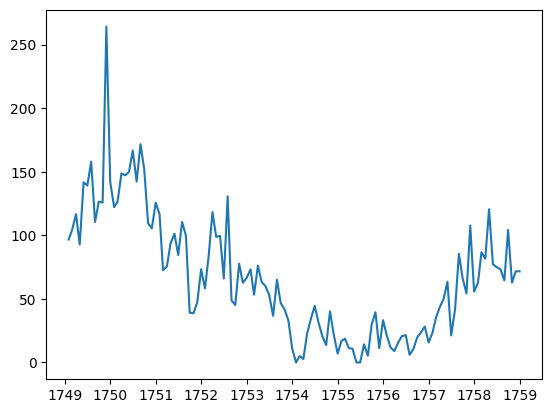

In [29]:
years = 10
plt.plot(sunspots_df.Date.iloc[: years * 12], sunspots_df.sunspots.iloc[: years * 12])

<Axes: >

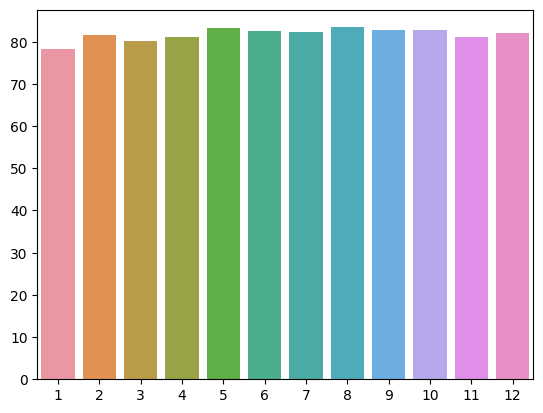

In [30]:
y = sunspots_df.groupby(sunspots_df.Date.dt.month)["sunspots"].mean().values
sns.barplot(x=list(range(1, 13)), y=y)


In [31]:
from sklearn.preprocessing import MinMaxScaler

def ts2dataset(values, input_size, output_size, stride=1):
    X = []
    y = []
    for i in range(0, len(values) - output_size - input_size, stride):
        X.append(values[i : i + input_size])
        y.append(values[i + input_size : i + input_size + output_size])
    return np.array(X), np.array(y)

INPUT_SIZE = 12
OUTPUT_SIZE = 2

series = sunspots_train_df.sunspots.values
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
X, y = ts2dataset(series_scaled, INPUT_SIZE, OUTPUT_SIZE)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# LSTM

In [37]:
# build lstm model in torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything


class LSTMRegressor(pl.LightningModule):

    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # result = pl.TrainResult(loss)
        # result.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # result = pl.EvalResult(checkpoint_on=loss)
        # result.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # result = pl.EvalResult()
        # result.log('test_loss', loss)
        return loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = LSTMRegressor(n_features=1, hidden_size=32, seq_len=12, batch_size=32, num_layers=2, dropout=0.2, learning_rate=0.01, criterion=nn.MSELoss())

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float().unsqueeze(-1), torch.from_numpy(y_train).float()), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float().unsqueeze(-1), torch.from_numpy(y_test).float()), batch_size=32, shuffle=True)


Using device: cpu


In [38]:
trainer = Trainer(max_epochs=400)
trainer.fit(model, train_loader, test_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 12.9 K
2 | linear    | Linear  | 33    
--------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Epoch 399: 100%|██████████| 80/80 [00:00<00:00, 122.78it/s, v_num=3]        

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 80/80 [00:00<00:00, 121.03it/s, v_num=3]


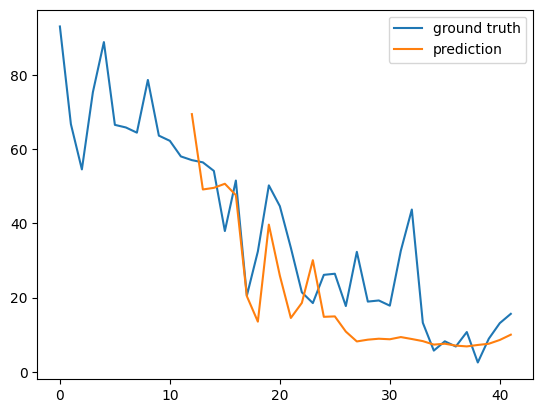

In [43]:
def plot_predictions(model, test_series, input_size, output_size, scaler):
    X, y = ts2dataset(test_series, input_size, output_size, stride=output_size)
    X = scaler.transform(X.reshape(-1, 1)).reshape(-1, input_size)
    X = torch.from_numpy(X).float().unsqueeze(-1)
    y = torch.from_numpy(y).float()
    model.eval()
    with torch.no_grad():
        y_hat = model(X).detach().numpy()
    y_hat = y_hat.reshape(-1, 1)
    y_hat = scaler.inverse_transform(y_hat).flatten()

    prediction_len = input_size + len(y_hat)
    plt.plot(np.arange(prediction_len), test_series[:prediction_len], label="ground truth")
    plt.plot(np.arange(input_size, prediction_len), y_hat, label="prediction")
    plt.legend()
    plt.show()


plot_predictions(model, sunspots_test_df.sunspots.values, INPUT_SIZE, OUTPUT_SIZE, scaler)

# ESN